In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor()
    ])
    image = PIL.Image.open(img_path).convert('RGB') # file -> RGB image
    image = loader(image).unsqueeze(0) # + batch size
    return image.to(device, torch.float) # using GPU

def imshow(tensor):
    image = tensor.cpu().clone() # GPU --> CPU
    image = image.squeeze(0) # - batch size
    from_tensor = transforms.ToPILImage()
    image = from_tensor(image) # tensor --> PIL.Image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Image Reconstruction

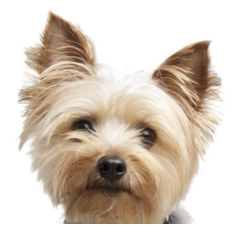

In [51]:
img_path = 'york.png'
target_image = image_loader(img_path, (512,512))
imshow(target_image)

In [52]:
noise = torch.empty_like(target_image)
noise = noise.uniform_(0, 1)
noise = noise.to(device)
noise

tensor([[[[0.7288, 0.5174, 0.6232,  ..., 0.1513, 0.4407, 0.9690],
          [0.0373, 0.1112, 0.6195,  ..., 0.2776, 0.3808, 0.1111],
          [0.7072, 0.6063, 0.7357,  ..., 0.8736, 0.1250, 0.0772],
          ...,
          [0.9092, 0.7741, 0.1605,  ..., 0.9463, 0.7713, 0.2803],
          [0.0323, 0.4733, 0.7971,  ..., 0.9952, 0.6934, 0.1501],
          [0.1858, 0.8413, 0.4279,  ..., 0.8088, 0.4881, 0.3204]],

         [[0.7697, 0.7151, 0.0250,  ..., 0.1028, 0.6799, 0.8011],
          [0.8922, 0.3293, 0.6926,  ..., 0.7728, 0.7695, 0.7534],
          [0.8155, 0.3050, 0.6131,  ..., 0.5633, 0.0666, 0.4182],
          ...,
          [0.0991, 0.3899, 0.8450,  ..., 0.2567, 0.6402, 0.9150],
          [0.5401, 0.4455, 0.5488,  ..., 0.6505, 0.7591, 0.9594],
          [0.9587, 0.0953, 0.6098,  ..., 0.2416, 0.4917, 0.4649]],

         [[0.1511, 0.6754, 0.9049,  ..., 0.8666, 0.1053, 0.5200],
          [0.6062, 0.6959, 0.4377,  ..., 0.7568, 0.9322, 0.5765],
          [0.8606, 0.4502, 0.0454,  ..., 0

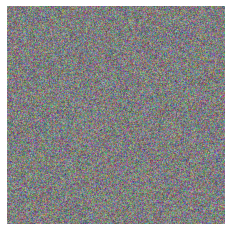

In [53]:
imshow(noise)

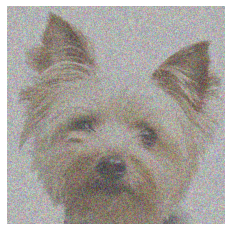

iter : 20 | loss : 0.08097167313098907


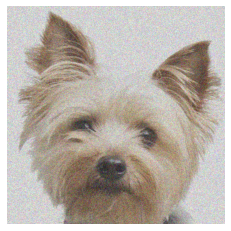

iter : 40 | loss : 0.02889556810259819


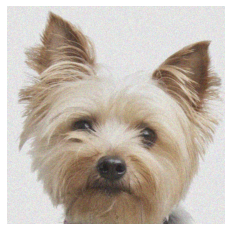

iter : 60 | loss : 0.010311678051948547


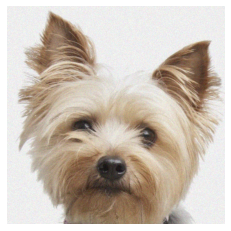

iter : 80 | loss : 0.003679826855659485


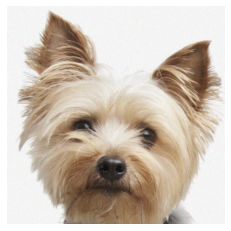

iter : 100 | loss : 0.0013131838059052825


In [54]:
loss = nn.MSELoss()
lr = 1e4

for i in range(1,101):
    noise.requires_grad = True # update noise to be similar to the target image
    output = loss(noise, target_image) # Calculate Mean Squared Error
    output.backward()

    gradient = lr * noise.grad # get gradient
    noise = noise - gradient # gradient descent
    noise = torch.clamp(noise, min=0, max=1).detach_() # scaling noise to range 0~1 and stopping to track the gradinet

    if i % 20 == 0:
        imshow(noise)
        print('iter : {} | loss : {}'.format(i,output))




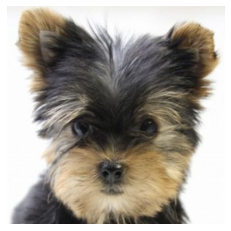

In [55]:
style_img = image_loader('york_puppy.png', (512,512))
imshow(style_img)

In [33]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() # only get feature maps
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [56]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [66]:
def gram_matrix(input):
    batch, channel, height, width = input.size() # torch's tensor structure : (N, C, H, W)
    features = input.view(batch*channel, height*width)
    gram = torch.mm(features, features.t()) # Matrix Multiplication
    return gram.div(batch*channel*height*width)

class StyleLoss(nn.Module): # calculate style loss
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_features).detach()

    def forward(self, input):
        gram = gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target)
        return input


In [58]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_losses(cnn, style_img, noise_img):
    cnn = copy.deepcopy(cnn) #copy neural net
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children(): # get each name of layers
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False) #inplace=True --> False
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecogsized layer : {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)

        if name in style_layers:
            target_features = model(style_img).detach()
            style_loss = StyleLoss(target_features) # get loss from gram_matrix
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)] #total layers : normalization ~ style loss
    return model, style_losses


In [68]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= iters:
        def closure():
            input_img.data.clamp_(0,1) # reset range 0~1
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for loss in style_losses:
                style_score += loss.loss

            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('iter : {} | loss : {}'.format(run[0], style_score.item()))
                imshow(input_img)
            
            return style_score

        optimizer.step(closure) # gradient descent

    input_img.data.clamp_(0,1) # reset range 0~1

    return input_img

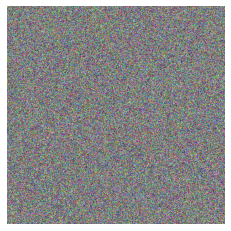

In [64]:
input_img = torch.empty_like(target_image) # get noise 
input_img = input_img.uniform_(0, 1)
input_img = input_img.to(device)
imshow(input_img)

iter : 50 | loss : 161.11097717285156


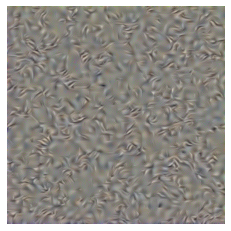

iter : 100 | loss : 110.52289581298828


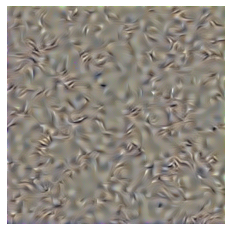

iter : 150 | loss : 92.33588409423828


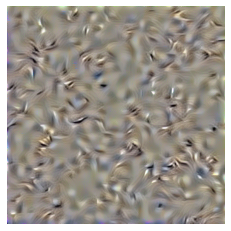

iter : 200 | loss : 73.09578704833984


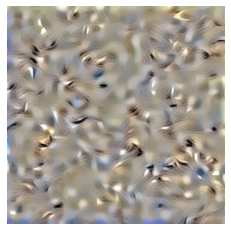

iter : 250 | loss : 50.502647399902344


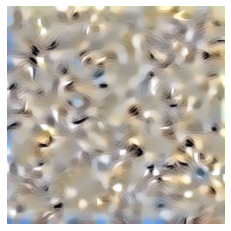

iter : 300 | loss : 36.5196647644043


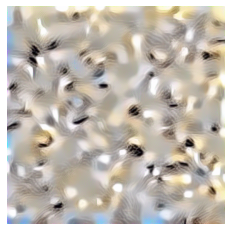

In [69]:
output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)

In [80]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [81]:
content_layers = ['conv_5']

def get_content_losses(cnn, content_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
    
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses

In [85]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('iter : {} | loss : {}'.format(run[0], content_score.item()))
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

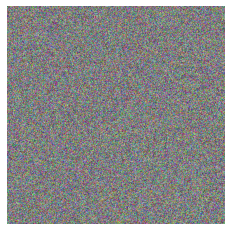

In [86]:
input_img = torch.empty_like(target_image) # get noise 
input_img = input_img.uniform_(0, 1)
input_img = input_img.to(device)
imshow(input_img)

iter : 50 | loss : 3.5492000579833984


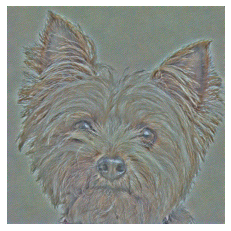

iter : 100 | loss : 2.0729079246520996


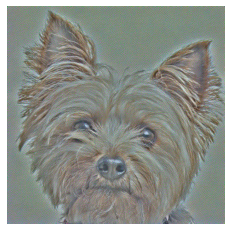

iter : 150 | loss : 1.5937103033065796


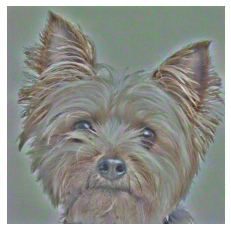

iter : 200 | loss : 1.344496488571167


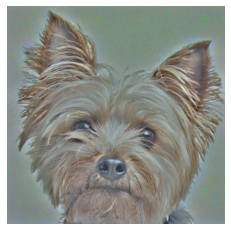

iter : 250 | loss : 1.1846342086791992


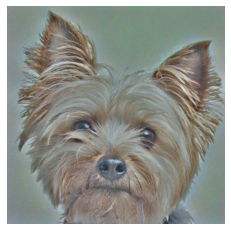

iter : 300 | loss : 1.070618748664856


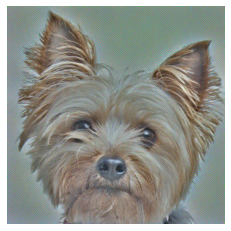

In [87]:
output = content_reconstruction(cnn, content_img=target_image, input_img=input_img, iters=300)

In [97]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']

def get_losses(cnn, content_img, style_img, noise_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)

        if name in content_layers:
            target_features = model(content_img).detach()
            content_loss = ContentLoss(target_features)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_features = model(style_img).detach()
            style_loss = StyleLoss(target_features)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i+1)]
    return model, content_losses, style_losses

In [98]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0,1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)

            return content_score + style_score

        optimizer.step(closure)

    input_img.data.clamp_(0,1)
    return input_img

[Content Image]


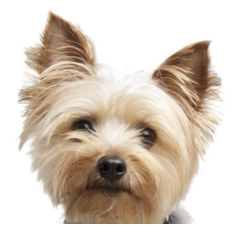

[Style Image]


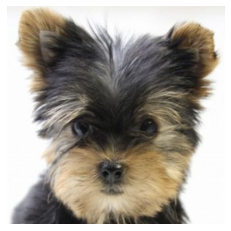

In [92]:
content_img = target_image
print('[Content Image]')
imshow(content_img)
print('[Style Image]')
imshow(style_img)

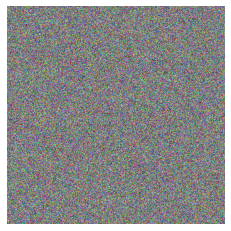

In [93]:
input_img = torch.empty_like(content_img).uniform_(0,1).to(device)
imshow(input_img)

[ Step: 100 / Content loss: 11.660324096679688 / Style loss: 13.538749694824219]


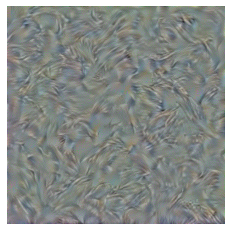

[ Step: 200 / Content loss: 7.705026149749756 / Style loss: 7.674911975860596]


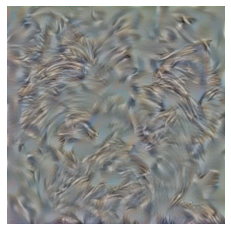

[ Step: 300 / Content loss: 5.56794548034668 / Style loss: 5.920202732086182]


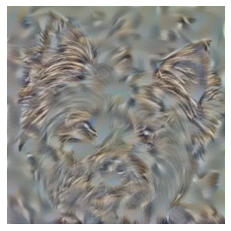

[ Step: 400 / Content loss: 4.415525436401367 / Style loss: 4.944511890411377]


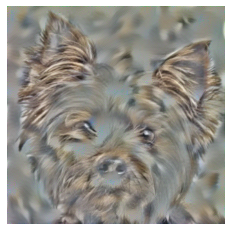

[ Step: 500 / Content loss: 3.756568431854248 / Style loss: 4.189581394195557]


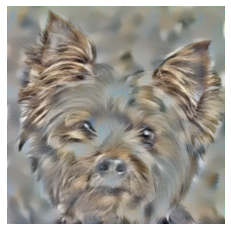

[ Step: 600 / Content loss: 3.3380062580108643 / Style loss: 3.446780204772949]


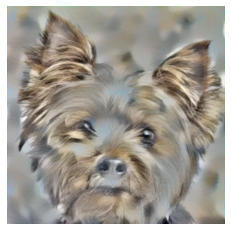

[ Step: 700 / Content loss: 3.04725980758667 / Style loss: 2.7414636611938477]


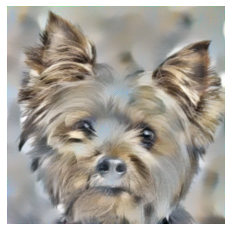

[ Step: 800 / Content loss: 2.8225016593933105 / Style loss: 2.1578855514526367]


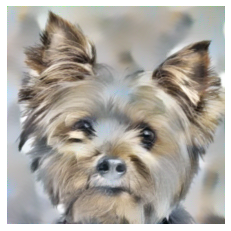

[ Step: 900 / Content loss: 2.6229019165039062 / Style loss: 1.759329080581665]


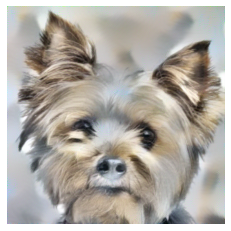

[ Step: 1000 / Content loss: 2.4440550804138184 / Style loss: 1.510189175605774]


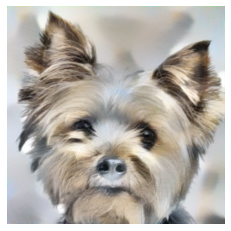

In [99]:
output = style_transfer(cnn, content_img = content_img, style_img = style_img, input_img = input_img, iters=1000)

[ Step: 100 / Content loss: 2.322993040084839 / Style loss: 1.3908778429031372]


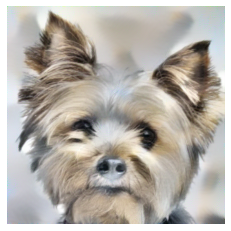

[ Step: 200 / Content loss: 2.218538761138916 / Style loss: 1.3032022714614868]


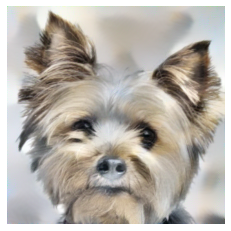

[ Step: 300 / Content loss: 2.1179494857788086 / Style loss: 1.2148380279541016]


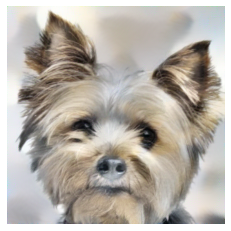

[ Step: 400 / Content loss: 2.0287556648254395 / Style loss: 1.0825691223144531]


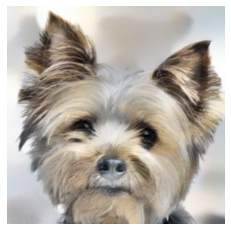

[ Step: 500 / Content loss: 1.9740513563156128 / Style loss: 0.9836170673370361]


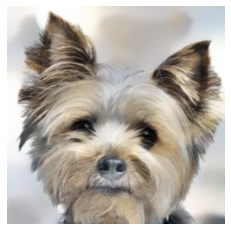

[ Step: 600 / Content loss: 1.9383671283721924 / Style loss: 0.8868981003761292]


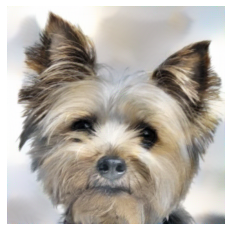

[ Step: 700 / Content loss: 2.4237143993377686 / Style loss: 2.2056097984313965]


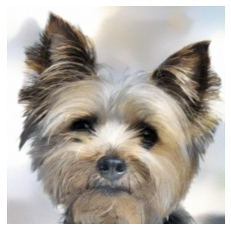

[ Step: 800 / Content loss: 1.8688793182373047 / Style loss: 0.7553238272666931]


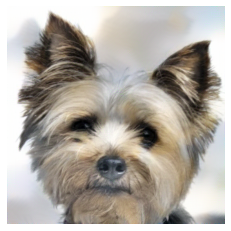

[ Step: 900 / Content loss: 1.8671809434890747 / Style loss: 0.6833361983299255]


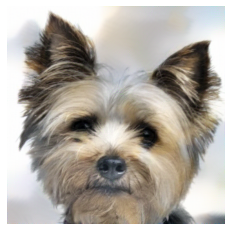

[ Step: 1000 / Content loss: 1.9606599807739258 / Style loss: 0.6407619118690491]


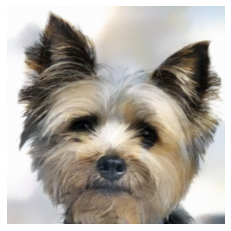

[ Step: 1100 / Content loss: 1.793689489364624 / Style loss: 0.5633257627487183]


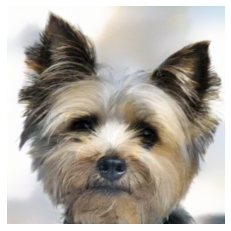

[ Step: 1200 / Content loss: 1.725290060043335 / Style loss: 0.5370595455169678]


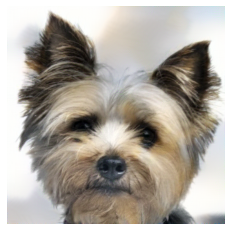

[ Step: 1300 / Content loss: 1.6858711242675781 / Style loss: 0.5693564414978027]


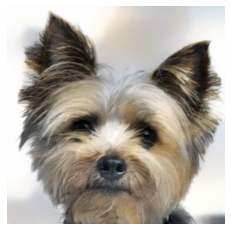

[ Step: 1400 / Content loss: 1.6493395566940308 / Style loss: 0.5121719241142273]


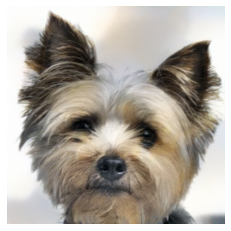

[ Step: 1500 / Content loss: 1.6220942735671997 / Style loss: 0.4953005909919739]


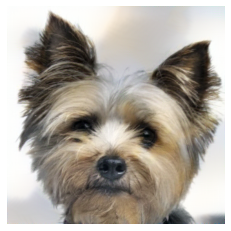

[ Step: 1600 / Content loss: 1.6008738279342651 / Style loss: 0.4853256940841675]


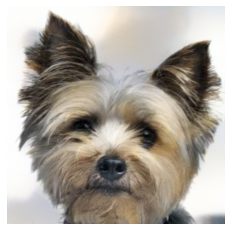

[ Step: 1700 / Content loss: 1.579716682434082 / Style loss: 0.47606268525123596]


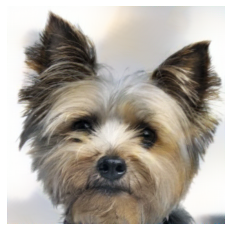

[ Step: 1800 / Content loss: 1.5854592323303223 / Style loss: 0.47432568669319153]


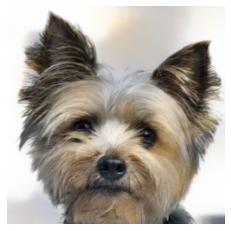

[ Step: 1900 / Content loss: 170.73399353027344 / Style loss: 292113.21875]


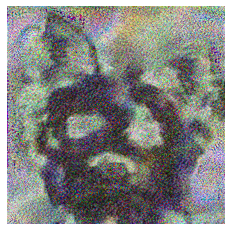

[ Step: 2000 / Content loss: 11.170791625976562 / Style loss: 9.219903945922852]


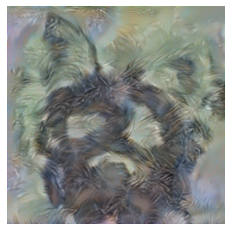

In [100]:
output = style_transfer(cnn, content_img = content_img, style_img = style_img, input_img = input_img, iters=2000)

[target]


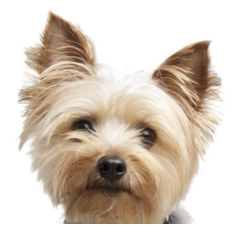

[style]


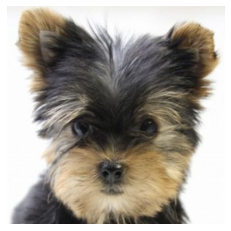

[result]


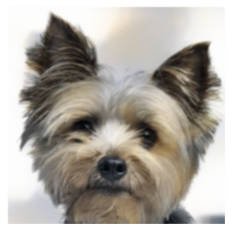

In [103]:
target = image_loader('york.png', (512,512))
style = image_loader('york_puppy.png', (512,512))
result = image_loader('result.png', (512,512))

print('[target]')
imshow(target)
print('[style]')
imshow(style)
print('[result]')
imshow(result)